In [1]:
%pylab inline
import json
from sklearn.metrics import confusion_matrix
import albumentations as A
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict
import torch.nn as nn
import numpy as np
import os
from neural_rock.model import NeuralRockModel
from neural_rock.server.utils import make_label_sets, init_model_zoo, model_lookup, load_image
from neural_rock.data_models import make_image_dataset, ModelName, LabelSetName, LabelSets
from neural_rock.preprocess import load_label_dataframe
import torch
from tqdm import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


## Loading the Dataset

In [2]:
valid_layers = {'resnet': list(range(8)), 'vgg': list(range(21))} # Valid Layers for each model type
base_path = Path("./") # Base path of data directories from environment variables
os.chdir("../") # Changing to workdir
print(os.getcwd())
# Load the dataframe of the Leg194 dataset
df = load_label_dataframe(base_path=base_path)

# Load the Image Dataset for the Thin Sections
image_dataset = make_image_dataset(df, base_path=base_path)

# Load the available label sets
label_sets = make_label_sets(df)

# Load the Model zoo of available pretrained models
model_zoo = init_model_zoo(base_path=base_path)

/home/lmoss/neural_rock_typing


## Function to predict probabilities

In [3]:
def predict_proba(model, X, device='cpu', ratio=224.0/512.0):
    transform = A.Compose([
        A.Resize(int(ratio * X.shape[0]), int(ratio * X.shape[1])),
        A.Normalize()])

    X = transform(image=X)['image'].transpose(2, 0, 1)
    X = torch.from_numpy(X).unsqueeze(0)
    X = X.to(device)

    with torch.no_grad():
        y_prob = torch.nn.functional.softmax(model(X), dim=1)
    return y_prob

## Make Confusion Matrices for all Models

/home/lmoss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/33 [00:00<?, ?it/s]

could not load image:  211


  0%|          | 0/34 [00:00<?, ?it/s]

/home/lmoss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/33 [00:00<?, ?it/s]

could not load image:  211


  0%|          | 0/34 [00:00<?, ?it/s]

/home/lmoss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/33 [00:00<?, ?it/s]

could not load image:  211


  0%|          | 0/34 [00:00<?, ?it/s]

/home/lmoss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/33 [00:00<?, ?it/s]

could not load image:  211


  0%|          | 0/34 [00:00<?, ?it/s]

/home/lmoss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/33 [00:00<?, ?it/s]

could not load image:  211


  0%|          | 0/34 [00:00<?, ?it/s]

/home/lmoss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/33 [00:00<?, ?it/s]

could not load image:  211


  0%|          | 0/34 [00:00<?, ?it/s]

/home/lmoss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/33 [00:00<?, ?it/s]

could not load image:  211


  0%|          | 0/34 [00:00<?, ?it/s]

/home/lmoss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/33 [00:00<?, ?it/s]

could not load image:  211


  0%|          | 0/34 [00:00<?, ?it/s]

/home/lmoss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

could not load image:  211


ValueError: 3 columns passed, passed data had 2 columns

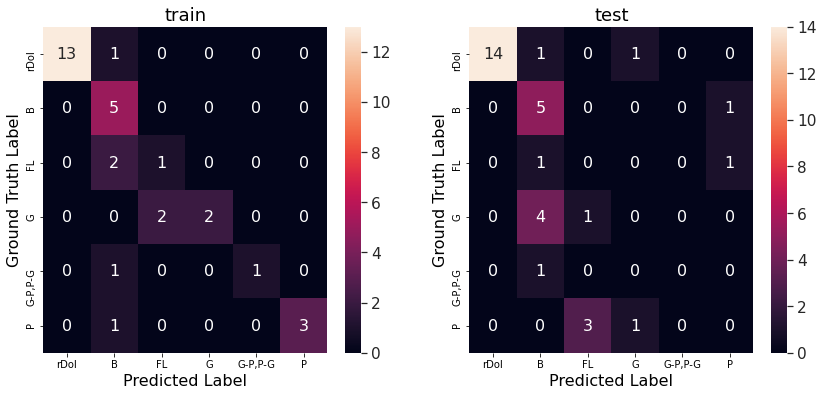

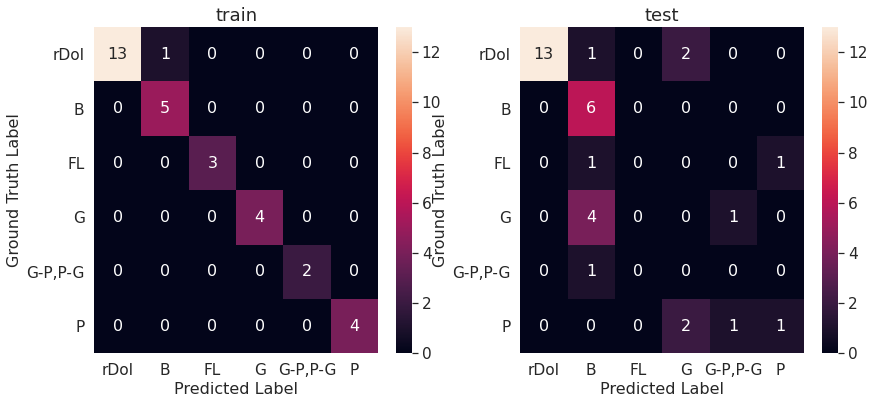

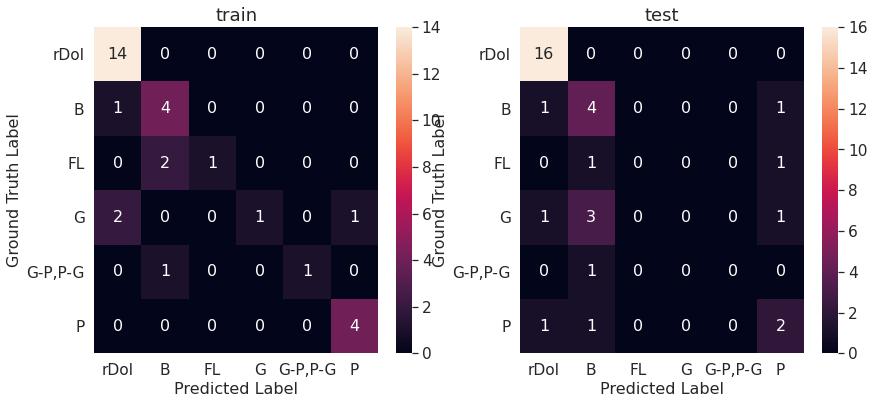

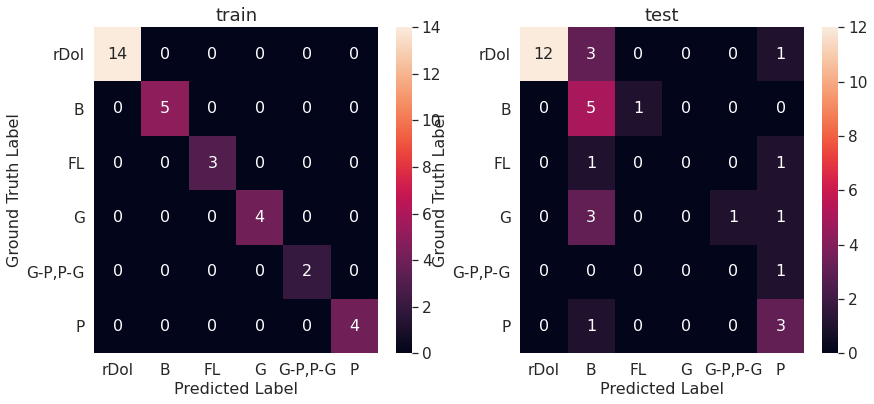

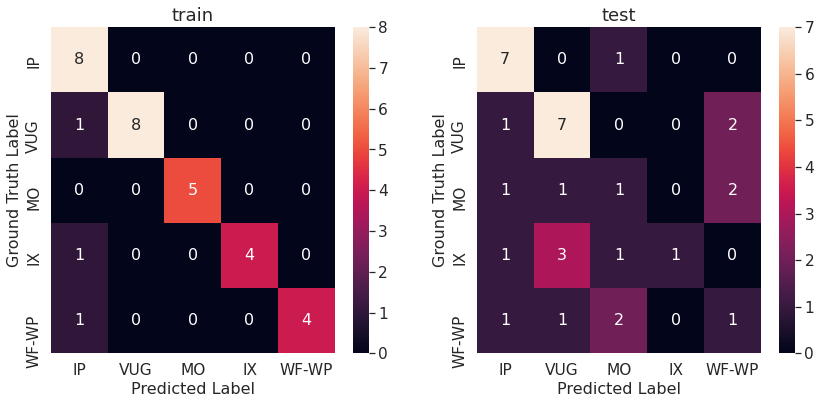

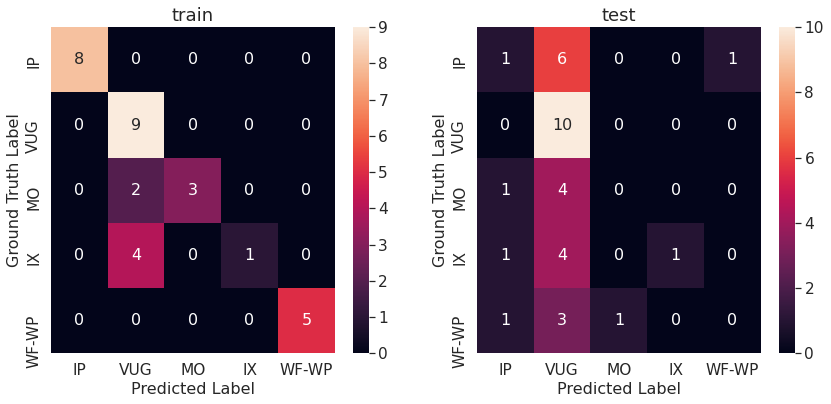

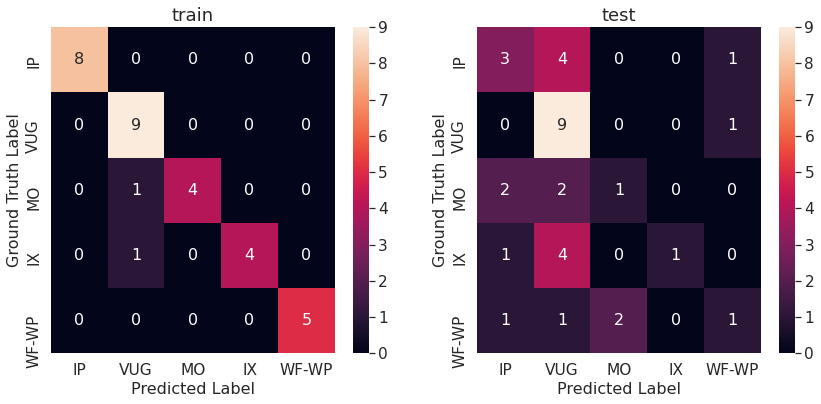

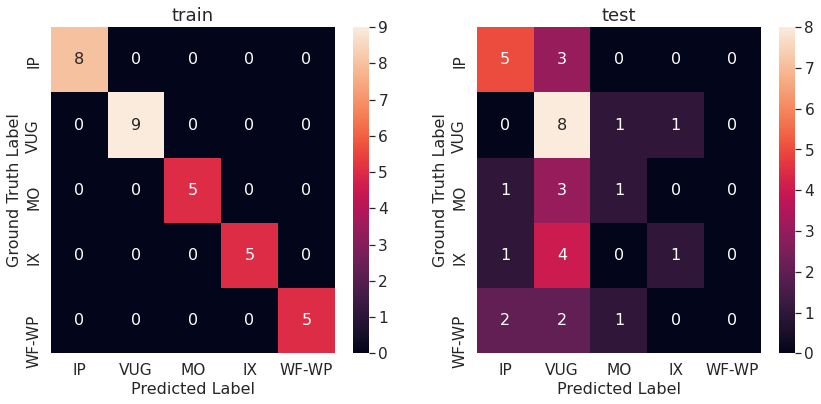

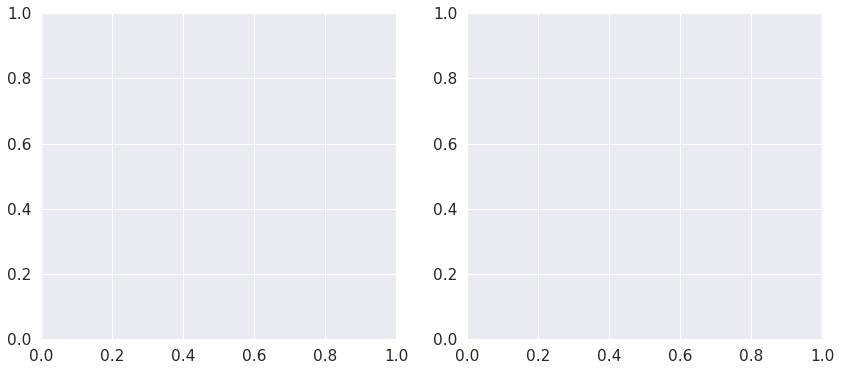

In [4]:
all_confusion_matrics = []
for label_set_name in [LabelSetName('Dunham'), LabelSetName('DominantPore'), LabelSetName('Lucia')]:
    for model_name in [ModelName('vgg'), ModelName('resnet')]:
        for frozen in [True, False]:
            device = 'cuda'
            label_set = label_sets.sets[label_set_name]

            model_config = model_lookup(model_zoo, label_set_name, model_name, frozen)

            feature_extractor, classifier = model_config.get_model(label_sets.sets[label_set_name].num_classes)

            model = NeuralRockModel(feature_extractor=feature_extractor,
                                    classifier=classifier,
                                    num_classes=label_sets.sets[label_set_name].num_classes)

            model = model.load_from_checkpoint(model_config.path)

            if model_config.model_name.lower() == 'resnet':
                model.feature_extractor = nn.Sequential(*list(model.feature_extractor.children()))

            model.eval()
            model.freeze()
            model = model.to(device)
            
            confusion_mat = {'train': None, 'test': None}
            predictions = {'train': [], 'test': []}
            
            for phase in ['train', 'test']:
                split = model_config.train_test_split[phase]
                for img_id in tqdm(split):
                    try:
                        img = load_image(image_dataset, img_id)
                        proba = predict_proba(model, img, device=device)
                        true_class_idx = label_set.get_sample_labels_as_class_idx()[img_id]
                        predicted_class_idx = torch.argmax(proba)
                        predictions[phase].append([predicted_class_idx.item(), true_class_idx])   
                    except KeyError:
                        print("could not load image: ", img_id)

            for phase in ['train', 'test']:
                X_pred = np.array(predictions[phase])
                con_mat = confusion_matrix(X_pred[:, 1], X_pred[:, 0])
                confusion_mat[phase] = con_mat.tolist()
                        
            all_confusion_matrics.append({'model_name': model_name, 
                                          'label_set_name': label_set_name, 
                                          'frozen': frozen, 
                                          'confusion_matrices': confusion_mat})
            
            fig, axarr = plt.subplots(1, 2, figsize=(14, 6))
            for ax, phase in zip(axarr, ["train", "test"]):
                df_cm = pd.DataFrame(confusion_mat[phase], label_set.class_names, label_set.class_names)
                # plt.figure(figsize=(10,7))
                sn.set(font_scale=1.4) # for label size
                sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, ax=ax) # font size
                ax.set_ylabel("Ground Truth Label", fontsize=16)
                ax.set_xlabel("Predicted Label", fontsize=16)
                ax.set_title(phase, fontsize=18)
            fig.savefig("./data/confusion_matrices/{0:}_{1:}_{2:}_confusion_matrix.png".format(label_set_name, model_name, frozen, phase),
                        bbox_inches="tight", 
                        dpi=72)

/home/lmoss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

could not load image:  211


/home/lmoss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

could not load image:  211


/home/lmoss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

could not load image:  211


/home/lmoss/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

could not load image:  211


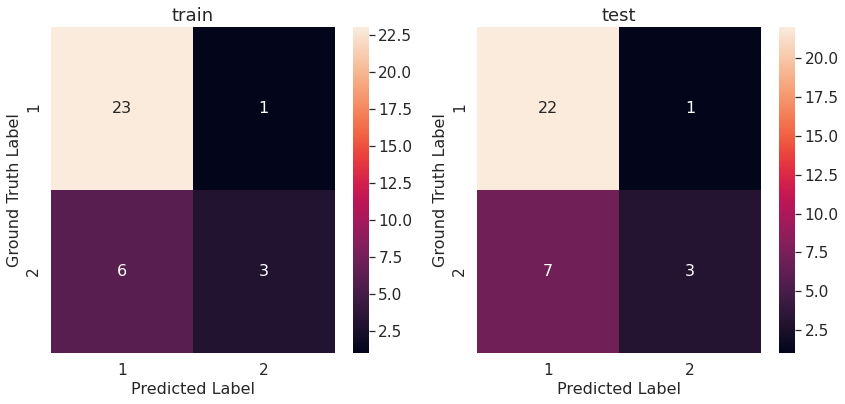

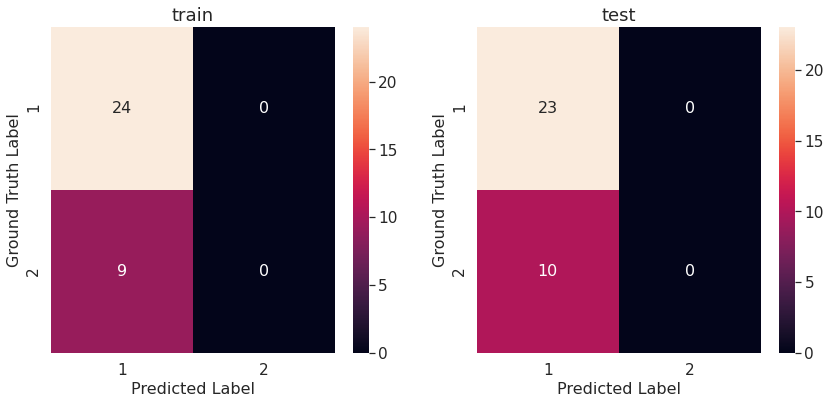

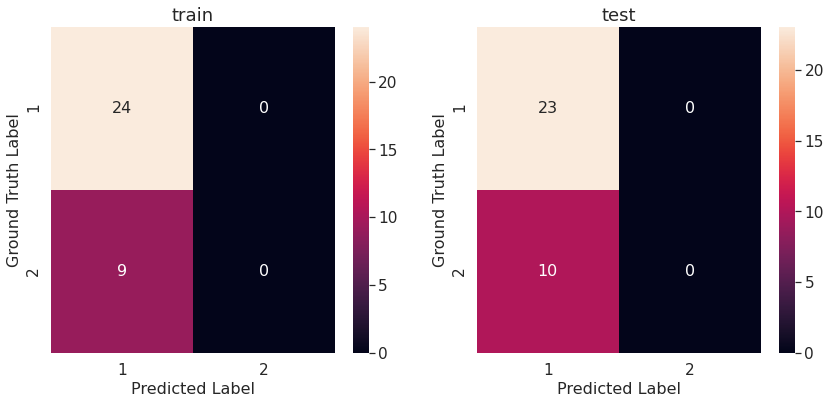

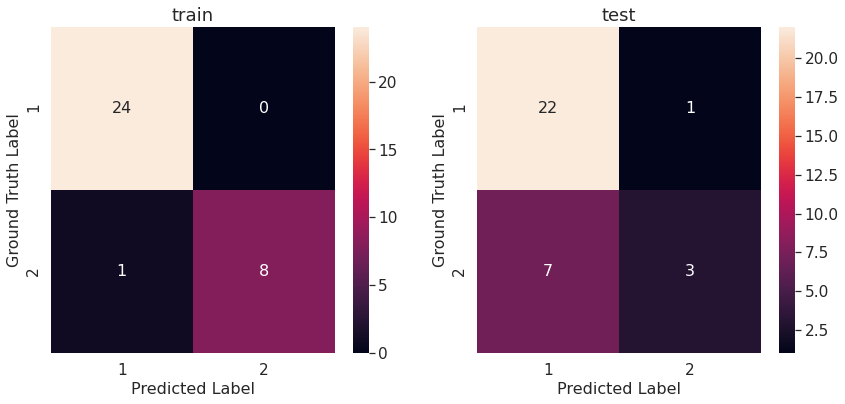

In [5]:
for label_set_name in [LabelSetName('Lucia')]:
    for model_name in [ModelName('vgg'), ModelName('resnet')]:
        for frozen in [True, False]:
            device = 'cuda'
            label_set = label_sets.sets[label_set_name]

            model_config = model_lookup(model_zoo, label_set_name, model_name, frozen)

            feature_extractor, classifier = model_config.get_model(label_sets.sets[label_set_name].num_classes)

            model = NeuralRockModel(feature_extractor=feature_extractor,
                                    classifier=classifier,
                                    num_classes=label_sets.sets[label_set_name].num_classes)

            model = model.load_from_checkpoint(model_config.path)

            if model_config.model_name.lower() == 'resnet':
                model.feature_extractor = nn.Sequential(*list(model.feature_extractor.children()))

            model.eval()
            model.freeze()
            model = model.to(device)
            
            confusion_mat = {'train': None, 'test': None}
            predictions = {'train': [], 'test': []}
            
            for phase in ['train', 'test']:
                split = model_config.train_test_split[phase]
                for img_id in tqdm(split):
                    try:
                        img = load_image(image_dataset, img_id)
                        proba = predict_proba(model, img, device=device)
                        true_class_idx = label_set.get_sample_labels_as_class_idx()[img_id]
                        predicted_class_idx = torch.argmax(proba)
                        predictions[phase].append([predicted_class_idx.item(), true_class_idx])   
                    except KeyError:
                        print("could not load image: ", img_id)

            for phase in ['train', 'test']:
                X_pred = np.array(predictions[phase])
                con_mat = confusion_matrix(X_pred[:, 1], X_pred[:, 0])
                confusion_mat[phase] = con_mat.tolist()
                        
            all_confusion_matrics.append({'model_name': model_name, 
                                          'label_set_name': label_set_name, 
                                          'frozen': frozen, 
                                          'confusion_matrices': confusion_mat})
            
            fig, axarr = plt.subplots(1, 2, figsize=(14, 6))
            for ax, phase in zip(axarr, ["train", "test"]):
                df_cm = pd.DataFrame(confusion_mat[phase], label_set.class_names[1:], label_set.class_names[1:])
                # plt.figure(figsize=(10,7))
                sn.set(font_scale=1.4) # for label size
                sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, ax=ax) # font size
                ax.set_ylabel("Ground Truth Label", fontsize=16)
                ax.set_xlabel("Predicted Label", fontsize=16)
                ax.set_title(phase, fontsize=18)
            fig.savefig("./data/confusion_matrices/{0:}_{1:}_{2:}_confusion_matrix.png".format(label_set_name, model_name, frozen, phase),
                        bbox_inches="tight", 
                        dpi=72)

In [7]:
print(os.getcwd())

/home/lmoss/neural_rock_typing


In [8]:
import json 

with open('./data/confusion_matrices/confusion_matrices.csv', 'w') as outfile:
    json.dump(all_confusion_matrics, outfile)

In [9]:
with open('./data/confusion_matrices/confusion_matrices.csv') as json_file:
    data = json.load(json_file)
    
print(data)

[{'model_name': 'vgg', 'label_set_name': 'Dunham', 'frozen': True, 'confusion_matrices': {'train': [[13, 1, 0, 0, 0, 0], [0, 5, 0, 0, 0, 0], [0, 2, 1, 0, 0, 0], [0, 0, 2, 2, 0, 0], [0, 1, 0, 0, 1, 0], [0, 1, 0, 0, 0, 3]], 'test': [[14, 1, 0, 1, 0, 0], [0, 5, 0, 0, 0, 1], [0, 1, 0, 0, 0, 1], [0, 4, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 3, 1, 0, 0]]}}, {'model_name': 'vgg', 'label_set_name': 'Dunham', 'frozen': False, 'confusion_matrices': {'train': [[13, 1, 0, 0, 0, 0], [0, 5, 0, 0, 0, 0], [0, 0, 3, 0, 0, 0], [0, 0, 0, 4, 0, 0], [0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 4]], 'test': [[13, 1, 0, 2, 0, 0], [0, 6, 0, 0, 0, 0], [0, 1, 0, 0, 0, 1], [0, 4, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0], [0, 0, 0, 2, 1, 1]]}}, {'model_name': 'resnet', 'label_set_name': 'Dunham', 'frozen': True, 'confusion_matrices': {'train': [[14, 0, 0, 0, 0, 0], [1, 4, 0, 0, 0, 0], [0, 2, 1, 0, 0, 0], [2, 0, 0, 1, 0, 1], [0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 0, 4]], 'test': [[16, 0, 0, 0, 0, 0], [1, 4, 0, 0, 0, 1], [0, 1, 0, 0, 0, 